# Base Field Model for NOAA 1158
Construct a base field model for AR NOAA 1158 that we can build several different heating models on top of.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map
from sunpy.net import Fido,attrs as a
from sunpy.time import TimeRange
import astropy.units as u
import sunpy.sun.constants as const
from astropy.coordinates import SkyCoord

import synthesizAR
from synthesizAR.util import heeq_to_hcc_coord
import synthesizAR.extrapolate

%matplotlib inline

Take a look at this particular region in a few different wavelengths as well as the magnetogram.

In [ ]:
q_aia = Fido.search(
    a.Time(TimeRange('2011/02/12 15:32:00',15 * u.s)),
    a.Instrument('AIA'),
    a.Wavelength(94*u.angstrom,171*u.angstrom)
)

In [ ]:
res = Fido.fetch(q_aia)

In [2]:
hmi_map = Map('/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits')
aia_94_map = Map('/storage-home/w/wtb2/sunpy/data/aia_lev1_94a_2011_02_12t15_32_14_12z_image_lev1.fits')
aia_131_map = Map('/storage-home/w/wtb2/sunpy/data/aia_lev1_131a_2011_02_12t15_32_09_63z_image_lev1.fits')
aia_171_map = Map('/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_02_12t15_32_12_34z_image_lev1.fits')

In [3]:
bottom_left_corner = u.Quantity([-440,-375],u.arcsec)
top_right_corner = u.Quantity([-140,-75],u.arcsec)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


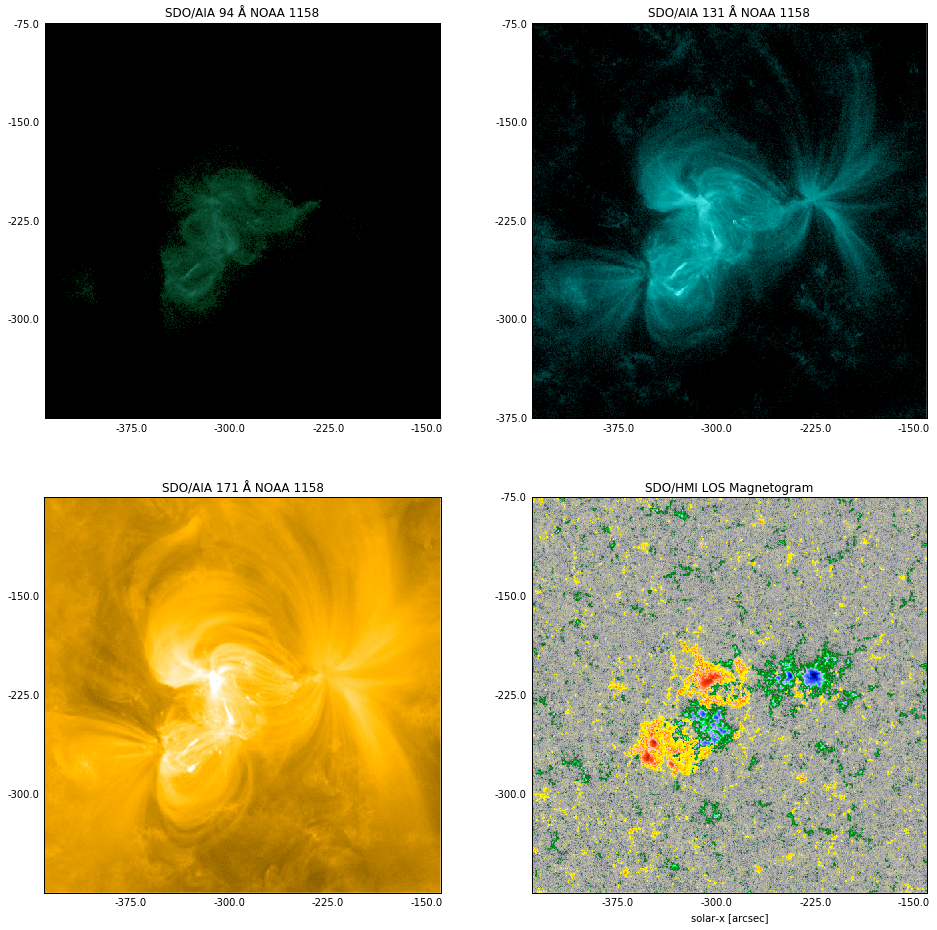

In [4]:
fig = plt.figure(figsize=(16,16))
norm = matplotlib.colors.SymLogNorm(1e-10,vmin=10,vmax=5e3)
## AIA
# 131
blc = SkyCoord(*bottom_left_corner, frame=aia_94_map.coordinate_frame)
trc = SkyCoord(*top_right_corner, frame=aia_94_map.coordinate_frame)
aia_94_submap = aia_94_map.submap(blc,trc)
ax = fig.add_subplot(2,2,1,projection=aia_94_submap)
aia_94_submap.plot(annotate=False,norm=norm)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/AIA 94 Å NOAA 1158')
# 131
blc = SkyCoord(*bottom_left_corner, frame=aia_131_map.coordinate_frame)
trc = SkyCoord(*top_right_corner, frame=aia_131_map.coordinate_frame)
aia_131_submap = aia_131_map.submap(blc,trc)
ax = fig.add_subplot(2,2,2,projection=aia_131_submap)
aia_131_submap.plot(annotate=False,norm=norm)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/AIA 131 Å NOAA 1158')
# 171
blc = SkyCoord(*bottom_left_corner, frame=aia_171_map.coordinate_frame)
trc = SkyCoord(*top_right_corner, frame=aia_171_map.coordinate_frame)
aia_171_submap = aia_171_map.submap(blc,trc)
ax = fig.add_subplot(2,2,3,projection=aia_171_submap)
aia_171_submap.plot(annotate=False,norm=norm)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/AIA 171 Å NOAA 1158')
## HMI
blc = SkyCoord(*bottom_left_corner, frame=hmi_map.coordinate_frame)
trc = SkyCoord(*top_right_corner, frame=hmi_map.coordinate_frame)
hmi_submap = hmi_map.rotate().submap(blc, trc)
ax = fig.add_subplot(2,2,4,projection=hmi_submap)
hmi_submap.plot(annotate=False,cmap='hmimag',vmin=-1.5e3,vmax=1.5e3)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/HMI LOS Magnetogram')
ax.set_xlabel(r'solar-x [arcsec]')

Now perform the extrapolation. We need to crop and resample the magnetogram as well.

In [5]:
shape_z = 100 * u.pixel
width_z = 0.3 * const.radius

In [6]:
blc = SkyCoord(*bottom_left_corner, frame=hmi_map.coordinate_frame)
trc = SkyCoord(*top_right_corner, frame=hmi_map.coordinate_frame)
magnetogram = hmi_map.rotate().submap(blc,trc).resample([100,100] * u.pixel)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


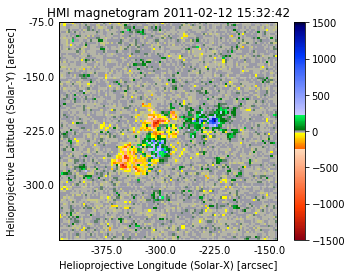

In [7]:
magnetogram.peek(cmap='hmimag',vmin=-1.5e3,vmax=1.5e3)

In [9]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram, width_z, shape_z)

In [10]:
B_field = extrapolator.extrapolate()

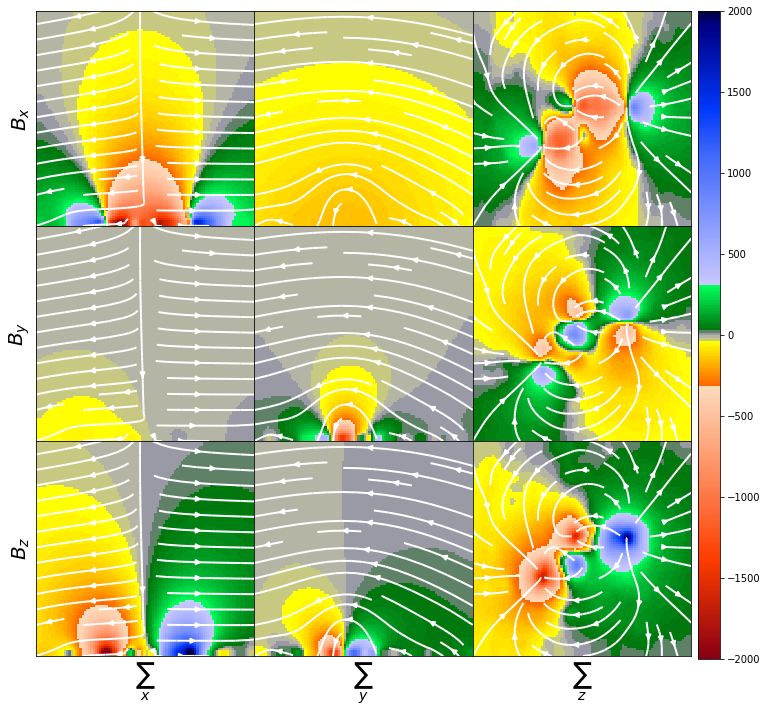

In [11]:
synthesizAR.extrapolate.peek_projections(B_field,)

Now trace the fieldlines

In [12]:
fieldlines = extrapolator.trace_fieldlines(B_field,5000,loop_length_range=[2e9,3e10]*u.cm,
                                           close_threshold=0.05,mask_threshold=0.075)

yt : [INFO     ] 2018-02-13 11:26:18,980 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-13 11:26:18,981 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-02-13 11:26:18,981 Parameters: domain_left_edge          = [ -1.31636400e+10  -1.10168955e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-13 11:26:18,982 Parameters: domain_right_edge         = [  1.18328215e+10   1.01326796e+10   2.08652400e+10]
yt : [INFO     ] 2018-02-13 11:26:18,982 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-13 11:26:19,659 AMRKDTree rebuilt, Final Volume: 1.103071e+31
Streamlining: 100%|██████████| 5000/5000 [00:06<00:00, 749.81it/s]
yt : [INFO     ] 2018-02-13 11:26:31,277 AMRKDTree rebuilt, Final Volume: 1.103071e+31
Streamlining: 100%|██████████| 2080/2080 [00:02<00:00, 720.93it/s]
yt : [INFO     ] 2018-02-13 11:26:36,125 AMRKDTree rebuilt, Final Volume: 1.103071e+31
Streamlining: 100%|██████████| 859/859 [00:01<00:00, 785.10it/s]
yt : [I

FloatProgress(value=0.0)

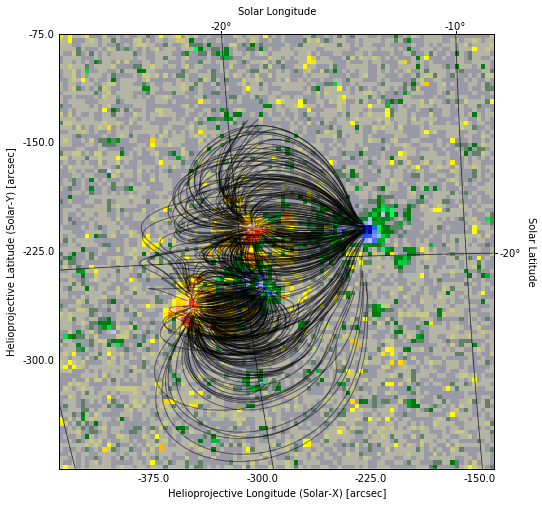

In [13]:
extrapolator.peek(fieldlines,line_frequency=10,alpha=0.5)

And finally, build the field

In [14]:
active_region = synthesizAR.Field(magnetogram,fieldlines=fieldlines)

We can examine the distribution of loop lengths over the whole AR.

Text(0,0.5,'Number of Strands')

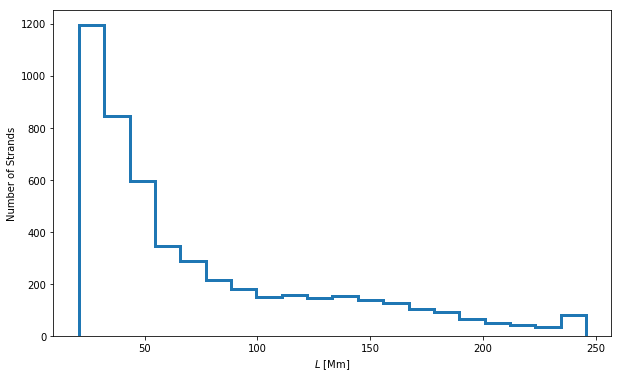

In [16]:
plt.figure(figsize=(10,6))
plt.hist([loop.full_length.to(u.Mm).value for loop in active_region.loops],histtype='step',lw=3,bins='scott');
plt.xlabel(r'$L$ [Mm]')
plt.ylabel(r'Number of Strands')
# plt.xscale('log')
# plt.yscale('log')

Now, we can visualize the the AIA observations with the extrapolated loops overlaid.

In [23]:
all_aia_maps = [aia_94_submap, aia_131_submap, aia_171_submap]

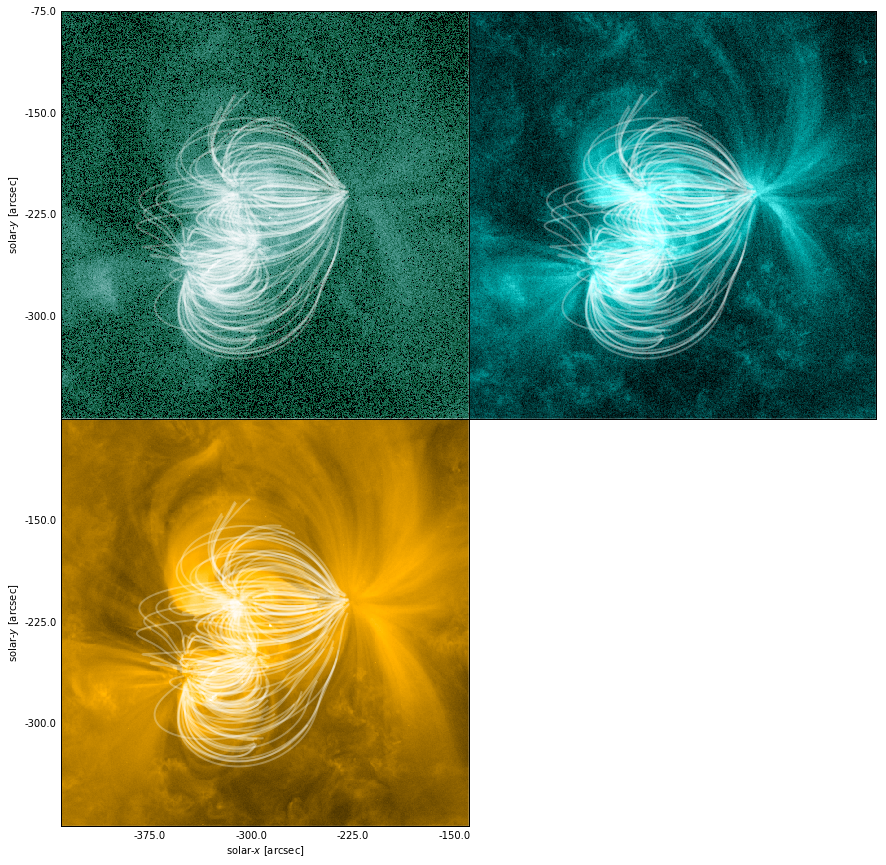

In [42]:
fig = plt.figure(figsize=(14.6,15))
plt.subplots_adjust(hspace=0,wspace=0)
for i,aia_map in enumerate(all_aia_maps):
    ax = fig.add_subplot(2,2,i+1,projection=aia_map)
    aia_map.plot(annotate=False,title=False, axes=ax, vmin=0,
                 #norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1,vmax=1e3),
                )
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    if i < 2:
        ax.coords[0].set_ticks_visible(False)
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.coords[0].set_axislabel(r'solar-$x$ [arcsec]')
    if i % 2 != 0:
        ax.coords[1].set_ticks_visible(False)
        ax.coords[1].set_ticklabel_visible(False)
    else:
        ax.coords[1].set_axislabel(r'solar-$y$ [arcsec]')
    for loop in active_region.loops[::25]:
        ax.plot_coord(heeq_to_hcc_coord(loop.coordinates[:,0],loop.coordinates[:,1],loop.coordinates[:,2],
                                        aia_map.observer_coordinate)
                      .transform_to(aia_map.coordinate_frame),
                      color='w',alpha=0.3,lw=2)

Finally, save the field to be reloaded later when we are investigating various heating models.

In [22]:
active_region.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158')